# Sentence Bert Model using Siamese Networks

In [1]:
# Import the necessary libraries for the project
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Set pandas display options for better visualization
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# Load the dataset into a pandas dataframe
qp = pd.read_csv('ques_pairs_extra.csv')
qp.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


## Features:

id - the id of a training set question pair

qid1, qid2 - unique ids of each question (only available in train.csv)

question1, question2 - the full text of each question

is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.


In [4]:
qp.shape # Returns the number of rows and columns in the dataframe

(404315, 6)

In [5]:
qp.info() # Provides information about the DataFrame including the index dtype and column dtypes, non-null values and memory usage.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404315 entries, 0 to 404314
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404315 non-null  int64 
 1   qid1          404315 non-null  int64 
 2   qid2          404315 non-null  int64 
 3   question1     404314 non-null  object
 4   question2     404313 non-null  object
 5   is_duplicate  404315 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


## EDA

In [6]:
qp.describe() # Generate descriptive statistics that summarize the central tendency, dispersion and shape of a dataset's distribution.

,id,qid1,qid2,is_duplicate
count,404315.000000,404315.000000,404315.000000,404315.000000
mean,202157.000000,217263.773122,220975.256597,0.369237
std,116715.831381,157766.979141,159917.666623,0.482599
min,0.000000,1.000000,2.000000,0.000000
25%,101078.500000,74448.500000,74734.000000,0.000000
50%,202157.000000,192199.000000,197077.000000,0.000000
75%,303235.500000,346604.000000,354720.500000,1.000000
max,404314.000000,537982.000000,537983.000000,1.000000


## Inference:

From above summary statistics and info, we are able to infer that:

1. There are no missing values
2. In, "is_duplicate" variable the mean is ~0.37, which means that there are 37% duplicates question pairs.

In [7]:
# Check for missing values
print(qp.isnull().sum())

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64


In [8]:
# Calculate the percentage of missing values in each column
missing_percent = qp.isnull().sum() * 100 / len(qp)

print(missing_percent)

id              0.000000
qid1            0.000000
qid2            0.000000
question1       0.000247
question2       0.000495
is_duplicate    0.000000
dtype: float64


In [9]:
# Display rows where 'question1' is missing
qp[qp['question1'].isnull()]

,id,qid1,qid2,question1,question2,is_duplicate
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English name is most suitable for me considering the pronounciation of my Chinese name?,0


In [10]:
# Display rows where 'question2' is missing
qp[qp['question2'].isnull()]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


## Inference:

Since the number of missing values is very small and question pairs are not present, we can remove these rows without impacting overall dataset.

In [11]:
# Drop the rows with missing values
qp = qp.dropna()

In [12]:
print(qp.isnull().sum())

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64


# Visualization:
## Distribution

In [13]:
# Count the number of each class in the 'is_duplicate' column
class_counts = qp['is_duplicate'].value_counts()

# Print the class counts
print(class_counts)

is_duplicate
0    255024
1    149288
Name: count, dtype: int64


In [14]:
# Calculate the percentage of each class
class_percentage = class_counts / len(qp) * 100

print(class_percentage)

is_duplicate
0    63.07604
1    36.92396
Name: count, dtype: float64


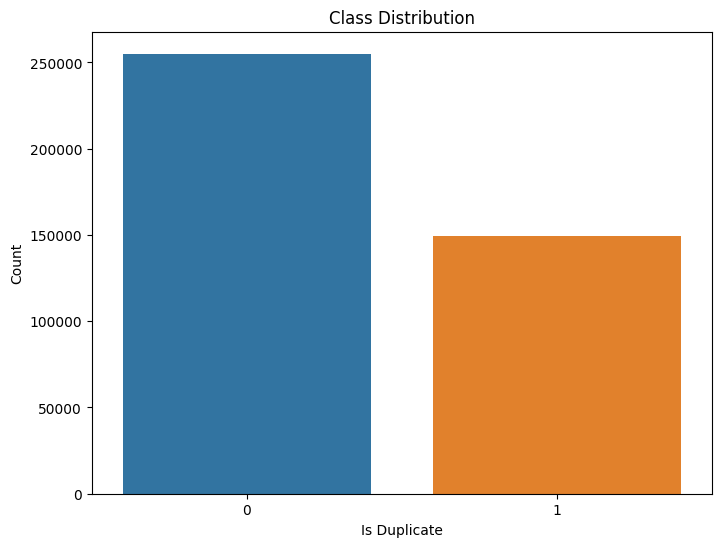

In [15]:
# Visualize the class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='is_duplicate', data=qp)
plt.title('Class Distribution')
plt.xlabel('Is Duplicate')
plt.ylabel('Count')
plt.show()

## Inference:

From above plot, we can see that the dataset is almost imbalanced, with a higher number of non-duplicate question pairs (class 0) than duplicate question pairs (class 1).

In [16]:
# Determine the number of samples from each class to take
num_samples_per_class = 200000 // len(qp['is_duplicate'].unique())

In [17]:
num_samples_per_class

100000

In [18]:
# stratified sampling to take into account of representative sample of data
questions = qp.groupby('is_duplicate').apply(lambda x: x.sample(num_samples_per_class, random_state=1)).reset_index(drop=True)

# Check the class distribution in the sample
print(questions['is_duplicate'].value_counts(normalize=True) * 100)

is_duplicate
0    50.0
1    50.0
Name: proportion, dtype: float64


In [19]:
len(questions)

200000

In [20]:
questions.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,293203,16206,414938,Can you be prosecuted for a crime committed in another country?,"Can someone be tried and/or sentenced to prison in a country he/she had never been before, and is not a citizen of that said country, for a crime he/she committed in another country?",0
1,238144,349452,349453,What is the most beautiful implementation of Convex Hull you have ever seen?,Which is the most delicate algorithm to implement?,0
2,136453,217718,203397,What are the best ways to forget the past?,How can one forget the past?,0
3,325263,451485,451486,How do I not make my boyfriend sad?,How can I make my selfish boyfriend love me?,0
4,184554,281939,281940,Is it true that the United States owes a lot of money to China?,What is a consecutive calendar day and how is it related with the Gaulish calendar?,0


In [21]:
questions.shape

(200000, 6)

## Length of questions

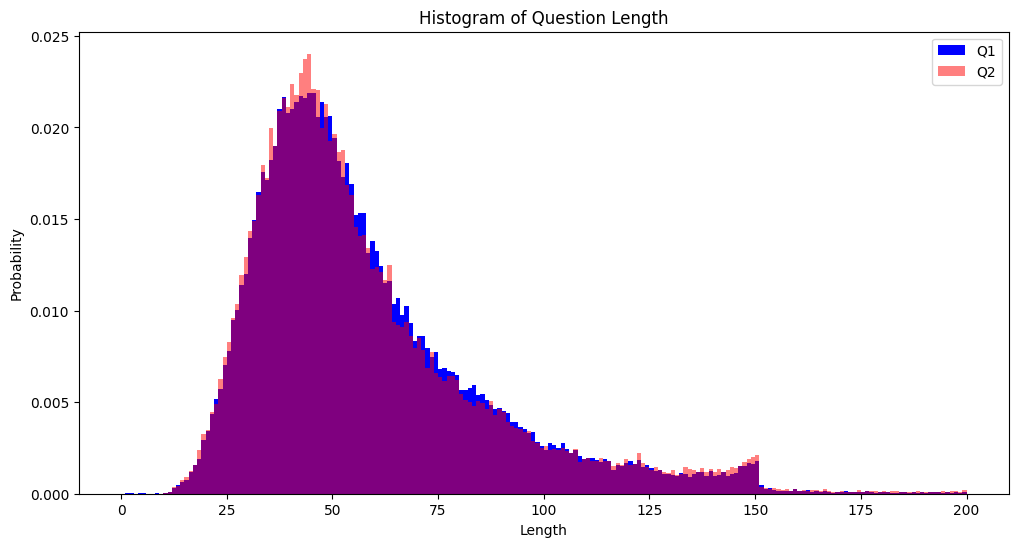

In [22]:
# Plot histogram of question lengths
plt.figure(figsize=(12, 6))
plt.hist(questions['question1'].str.len(), bins=200, range=[0, 200], color='blue', density=True, label='Q1')
plt.hist(questions['question2'].str.len(), bins=200, range=[0, 200], color='red', density=True, alpha=0.5, label='Q2')
plt.title('Histogram of Question Length')
plt.legend()
plt.xlabel('Length')
plt.ylabel('Probability')
plt.show()

In [23]:
questions.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,293203,16206,414938,Can you be prosecuted for a crime committed in another country?,"Can someone be tried and/or sentenced to prison in a country he/she had never been before, and is not a citizen of that said country, for a crime he/she committed in another country?",0
1,238144,349452,349453,What is the most beautiful implementation of Convex Hull you have ever seen?,Which is the most delicate algorithm to implement?,0
2,136453,217718,203397,What are the best ways to forget the past?,How can one forget the past?,0
3,325263,451485,451486,How do I not make my boyfriend sad?,How can I make my selfish boyfriend love me?,0
4,184554,281939,281940,Is it true that the United States owes a lot of money to China?,What is a consecutive calendar day and how is it related with the Gaulish calendar?,0


In [24]:
questions.shape

(200000, 6)

#### Note: It might be better to retain stopwords instead of removing it as for some questions it makes sense like for example, "How is the weather at california?" and "What is the climate at present?" are clearly not duplicates, but if we remove the stopwords 'is' and 'at', we might lose this distinction. Therefore, **it is better to keep stopwords in this case**.

In [26]:
# Sanity Check
## Check for empty and null strings in questions

empty_q1 = questions[questions['question1'] == ''].shape[0]
empty_q2 = questions[questions['question2'] == ''].shape[0]

print(f"Number of empty strings in 'question1': {empty_q1}")
print(f"Number of empty strings in 'question2': {empty_q2}")

null_q1 = questions['question1'].isnull().sum()
null_q2 = questions['question2'].isnull().sum()

print(f"Number of None values in 'question1': {null_q1}")
print(f"Number of None values in 'question2': {null_q2}")

Number of empty strings in 'question1': 0
Number of empty strings in 'question2': 0
Number of None values in 'question1': 0
Number of None values in 'question2': 0


## Note: Considering deep learning based NLP models like transformer models (BERT or RoBERTa) are designed to learn from raw text data and generate their own text representations, we dont exactly need preprocessing/feature engineering for this context.

## Model Building

In [34]:
questions_model=questions.copy()
questions_model.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,293203,16206,414938,Can you be prosecuted for a crime committed in another country?,"Can someone be tried and/or sentenced to prison in a country he/she had never been before, and is not a citizen of that said country, for a crime he/she committed in another country?",0
1,238144,349452,349453,What is the most beautiful implementation of Convex Hull you have ever seen?,Which is the most delicate algorithm to implement?,0
2,136453,217718,203397,What are the best ways to forget the past?,How can one forget the past?,0
3,325263,451485,451486,How do I not make my boyfriend sad?,How can I make my selfish boyfriend love me?,0
4,184554,281939,281940,Is it true that the United States owes a lot of money to China?,What is a consecutive calendar day and how is it related with the Gaulish calendar?,0


In [35]:
questions_model.shape

(200000, 6)

In [36]:
# Sanity Check
## Check for empty and null strings in questions

empty_q1 = questions_model[questions_model['question1'] == ''].shape[0]
empty_q2 = questions_model[questions_model['question2'] == ''].shape[0]

print(f"Number of empty strings in 'question1': {empty_q1}")
print(f"Number of empty strings in 'question2': {empty_q2}")

null_q1 = questions_model['question1'].isnull().sum()
null_q2 = questions_model['question2'].isnull().sum()

print(f"Number of None values in 'question1': {null_q1}")
print(f"Number of None values in 'question2': {null_q2}")

Number of empty strings in 'question1': 0
Number of empty strings in 'question2': 0
Number of None values in 'question1': 0
Number of None values in 'question2': 0


In [37]:
# !pip install transformers
# !pip install sentence-transformers

In [38]:
import torch
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer
from torch.nn import BCEWithLogitsLoss
from torch import nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

In [39]:
# Source: https://towardsdatascience.com/quick-semantic-search-using-siamese-bert-networks-1052e7b4df1
# Source: http://cs230.stanford.edu/projects_fall_2021/reports/102673633.pdf

# Defining the Siamese Sentence-BERT Network
class SiameseSentenceBERT(nn.Module):
    def __init__(self, model_name='all-MiniLM-L6-v2', dropout_rate=0.1):
        super(SiameseSentenceBERT, self).__init__()

        # Use the SentenceTransformer class to create a BERT model that can encode sentences
        self.bert = SentenceTransformer(model_name)

        # dropout layer to reduce overfitting
        self.dropout = nn.Dropout(dropout_rate)

        # Create two fully connected layers to output a single value (binary classification)
        self.fc1 = nn.Linear(self.bert.get_sentence_embedding_dimension() * 2, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, question1, question2):

        # Encode each question into a vector representation using the BERT model
        question1_embedding = self.bert.encode(question1, convert_to_tensor=True)
        question2_embedding = self.bert.encode(question2, convert_to_tensor=True)

        # Combine the two question embeddings into one vector
        combined_embedding = torch.cat((question1_embedding, question2_embedding), dim=1)

        # Apply dropout to the combined embedding
        dropped_out_embedding = self.dropout(combined_embedding)

        # Apply the fully connected layers to output a single value
        fc1_output = self.fc1(dropped_out_embedding)
        fc2_output = self.fc2(fc1_output)

        # Apply a sigmoid function to squish the output value between 0 and 1
        output = torch.sigmoid(fc2_output)

        # Remove the extra dimension from the output
        return output.squeeze()

In [40]:
# Checking if CUDA is available and setting device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a PyTorch Dataset class for holding the Quora questions data
class QuoraDataset(Dataset):
    def __init__(self, questions1, questions2, labels):
        self.questions1 = questions1
        self.questions2 = questions2
        self.labels = labels

    # The length method returns the total number of question pairs
    def __len__(self):
        return len(self.questions1)

    # The getitem method defines how to access a question pair and its associated label by index
    def __getitem__(self, idx):
        return self.questions1[idx], self.questions2[idx], self.labels[idx]

# Extracting questions and labels from the dataset
questions1 = list(questions_model['question1'])
questions2 = list(questions_model['question2'])
labels = list(questions_model['is_duplicate'])

# Splitting the data into training and validation sets
questions1_train, questions1_val, questions2_train, questions2_val, labels_train, labels_val = train_test_split(
    questions1, questions2, labels, test_size=0.2, random_state=42)

# Creating DataLoaders for training and validation sets
train_dataset = QuoraDataset(questions1_train, questions2_train, labels_train)
val_dataset = QuoraDataset(questions1_val, questions2_val, labels_val)

train_data = DataLoader(train_dataset, batch_size=64)
val_data = DataLoader(val_dataset, batch_size=64)

In [41]:
# Initialize the SiameseSentenceBERT model and move it to the appropriate device
model = SiameseSentenceBERT().to(device)
print(model)

SiameseSentenceBERT(
  (bert): SentenceTransformer(
    (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
    (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
    (2): Normalize()
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)


In [43]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define the loss function and optimizer
loss_function = BCEWithLogitsLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# Set the number of training epochs
num_epochs = 50

# Using ReduceLROnPlateau learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', verbose=True)

# Define a function to compute the loss and evaluation metrics for a batch of outputs and labels
def compute_metrics(outputs, labels):
    total_loss = loss_function(outputs, labels)
    preds = torch.where(outputs > 0.5, torch.ones_like(outputs), torch.zeros_like(outputs))
    acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
    f1 = f1_score(labels.cpu().numpy(), preds.cpu().numpy())
    return total_loss, acc, f1

# Define a function to train the model for one epoch
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    total_acc = 0
    total_f1 = 0
    for question1, question2, labels in tqdm(data_loader):
        labels = labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(question1, question2)
        loss, acc, f1 = compute_metrics(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += acc
        total_f1 += f1
    scheduler.step(total_loss)
    return total_loss/len(data_loader), total_acc/len(data_loader), total_f1/len(data_loader)

# Define a function to evaluate the model on a data set
def eval_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    total_acc = 0
    total_f1 = 0
    with torch.no_grad():
        for question1, question2, labels in data_loader:
            labels = labels.float().to(device)
            outputs = model(question1, question2)
            loss, acc, f1 = compute_metrics(outputs, labels)
            total_loss += loss.item()
            total_acc += acc
            total_f1 += f1
    return total_loss/len(data_loader), total_acc/len(data_loader), total_f1/len(data_loader)

# Track the accuracy and loss over time
train_accs = []
val_accs = []
train_losses = []
val_losses = []

#Training Loop
for epoch in range(num_epochs):
    train_loss, train_acc, train_f1 = train_epoch(model, train_data, optimizer, device)
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Train F1: {train_f1:.3f}')

    val_loss, val_acc, val_f1 = eval_model(model, val_data, device)
    val_accs.append(val_acc)
    val_losses.append(val_loss)
    print(f'Epoch: {epoch+1:02} | Val Loss: {val_loss:.3f} | Val Acc: {val_acc*100:.2f}% | Val F1: {val_f1:.3f}')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:45<00:00, 15.07it/s]


Epoch: 01 | Train Loss: 0.644 | Train Acc: 66.79% | Train F1: 0.582
Epoch: 01 | Val Loss: 0.644 | Val Acc: 66.84% | Val F1: 0.582


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:48<00:00, 14.84it/s]


Epoch: 02 | Train Loss: 0.644 | Train Acc: 66.82% | Train F1: 0.581
Epoch: 02 | Val Loss: 0.644 | Val Acc: 66.81% | Val F1: 0.583


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:34<00:00, 16.13it/s]


Epoch: 03 | Train Loss: 0.644 | Train Acc: 66.88% | Train F1: 0.583
Epoch: 03 | Val Loss: 0.645 | Val Acc: 67.12% | Val F1: 0.595


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:46<00:00, 15.00it/s]


Epoch: 04 | Train Loss: 0.644 | Train Acc: 66.92% | Train F1: 0.584
Epoch: 04 | Val Loss: 0.645 | Val Acc: 66.62% | Val F1: 0.578


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:33<00:00, 16.33it/s]


Epoch: 05 | Train Loss: 0.644 | Train Acc: 66.99% | Train F1: 0.586
Epoch: 05 | Val Loss: 0.645 | Val Acc: 66.96% | Val F1: 0.590


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:05<00:00, 19.88it/s]


Epoch: 06 | Train Loss: 0.644 | Train Acc: 66.91% | Train F1: 0.585
Epoch: 06 | Val Loss: 0.644 | Val Acc: 66.81% | Val F1: 0.585


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:15<00:00, 18.43it/s]


Epoch: 07 | Train Loss: 0.643 | Train Acc: 67.10% | Train F1: 0.587
Epoch: 07 | Val Loss: 0.644 | Val Acc: 66.83% | Val F1: 0.583


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:35<00:00, 16.04it/s]


Epoch: 08 | Train Loss: 0.643 | Train Acc: 67.09% | Train F1: 0.588
Epoch: 08 | Val Loss: 0.644 | Val Acc: 66.92% | Val F1: 0.585


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [12:45<00:00,  3.27it/s]


Epoch: 09 | Train Loss: 0.643 | Train Acc: 67.21% | Train F1: 0.589
Epoch: 09 | Val Loss: 0.644 | Val Acc: 66.96% | Val F1: 0.588


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:05<00:00, 19.86it/s]


Epoch: 10 | Train Loss: 0.643 | Train Acc: 67.08% | Train F1: 0.587
Epoch: 10 | Val Loss: 0.644 | Val Acc: 66.83% | Val F1: 0.581


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:53<00:00, 14.43it/s]


Epoch: 11 | Train Loss: 0.643 | Train Acc: 67.08% | Train F1: 0.588
Epoch: 11 | Val Loss: 0.644 | Val Acc: 66.96% | Val F1: 0.589


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:44<00:00, 15.16it/s]


Epoch: 12 | Train Loss: 0.643 | Train Acc: 67.18% | Train F1: 0.588
Epoch: 12 | Val Loss: 0.644 | Val Acc: 66.43% | Val F1: 0.571


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [03:09<00:00, 13.17it/s]


Epoch: 13 | Train Loss: 0.643 | Train Acc: 67.24% | Train F1: 0.590
Epoch: 13 | Val Loss: 0.645 | Val Acc: 66.88% | Val F1: 0.587


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [03:24<00:00, 12.22it/s]


Epoch: 14 | Train Loss: 0.643 | Train Acc: 67.18% | Train F1: 0.589
Epoch: 14 | Val Loss: 0.645 | Val Acc: 66.70% | Val F1: 0.581


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:01<00:00, 20.51it/s]


Epoch: 15 | Train Loss: 0.643 | Train Acc: 67.16% | Train F1: 0.589
Epoch: 15 | Val Loss: 0.645 | Val Acc: 67.12% | Val F1: 0.595


 68%|█████████████████████████████████████████████████████████████████████████████                                     | 1691/2500 [02:09<00:42, 19.11it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [07:21<00:00,  5.66it/s]


Epoch: 24 | Train Loss: 0.643 | Train Acc: 67.08% | Train F1: 0.586
Epoch: 24 | Val Loss: 0.645 | Val Acc: 66.81% | Val F1: 0.584


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:11<00:00, 18.99it/s]


Epoch: 25 | Train Loss: 0.643 | Train Acc: 67.15% | Train F1: 0.587
Epoch: 25 | Val Loss: 0.645 | Val Acc: 66.48% | Val F1: 0.575


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:34<00:00, 16.16it/s]


Epoch: 26 | Train Loss: 0.643 | Train Acc: 67.28% | Train F1: 0.590
Epoch: 26 | Val Loss: 0.644 | Val Acc: 66.55% | Val F1: 0.575


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:28<00:00, 16.81it/s]


Epoch: 27 | Train Loss: 0.642 | Train Acc: 67.35% | Train F1: 0.593
Epoch: 27 | Val Loss: 0.645 | Val Acc: 67.19% | Val F1: 0.597


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [08:00<00:00,  5.20it/s]


Epoch: 28 | Train Loss: 0.642 | Train Acc: 67.27% | Train F1: 0.591
Epoch: 28 | Val Loss: 0.645 | Val Acc: 66.84% | Val F1: 0.587


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [07:16<00:00,  5.73it/s]


Epoch 00029: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 29 | Train Loss: 0.643 | Train Acc: 67.23% | Train F1: 0.589
Epoch: 29 | Val Loss: 0.645 | Val Acc: 66.81% | Val F1: 0.586


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:11<00:00, 18.96it/s]


Epoch: 30 | Train Loss: 0.644 | Train Acc: 66.88% | Train F1: 0.585
Epoch: 30 | Val Loss: 0.644 | Val Acc: 66.87% | Val F1: 0.583


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [01:56<00:00, 21.49it/s]


Epoch: 31 | Train Loss: 0.643 | Train Acc: 67.17% | Train F1: 0.589
Epoch: 31 | Val Loss: 0.643 | Val Acc: 67.14% | Val F1: 0.589


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:03<00:00, 20.18it/s]


Epoch: 32 | Train Loss: 0.643 | Train Acc: 67.13% | Train F1: 0.588
Epoch: 32 | Val Loss: 0.643 | Val Acc: 67.02% | Val F1: 0.585


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:14<00:00, 18.65it/s]


Epoch: 33 | Train Loss: 0.643 | Train Acc: 67.22% | Train F1: 0.589
Epoch: 33 | Val Loss: 0.643 | Val Acc: 67.05% | Val F1: 0.585


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:14<00:00, 18.56it/s]


Epoch: 34 | Train Loss: 0.643 | Train Acc: 67.21% | Train F1: 0.589
Epoch: 34 | Val Loss: 0.643 | Val Acc: 67.07% | Val F1: 0.586


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:13<00:00, 18.74it/s]


Epoch: 35 | Train Loss: 0.643 | Train Acc: 67.25% | Train F1: 0.590
Epoch: 35 | Val Loss: 0.643 | Val Acc: 67.06% | Val F1: 0.586


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:11<00:00, 19.05it/s]


Epoch: 36 | Train Loss: 0.643 | Train Acc: 67.18% | Train F1: 0.588
Epoch: 36 | Val Loss: 0.643 | Val Acc: 67.12% | Val F1: 0.589


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:13<00:00, 18.77it/s]


Epoch: 37 | Train Loss: 0.642 | Train Acc: 67.27% | Train F1: 0.590
Epoch: 37 | Val Loss: 0.643 | Val Acc: 67.03% | Val F1: 0.584


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:14<00:00, 18.61it/s]


Epoch: 38 | Train Loss: 0.643 | Train Acc: 67.16% | Train F1: 0.589
Epoch: 38 | Val Loss: 0.643 | Val Acc: 67.05% | Val F1: 0.585


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:14<00:00, 18.54it/s]


Epoch: 39 | Train Loss: 0.642 | Train Acc: 67.36% | Train F1: 0.592
Epoch: 39 | Val Loss: 0.643 | Val Acc: 67.22% | Val F1: 0.589


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:11<00:00, 18.96it/s]


Epoch: 40 | Train Loss: 0.643 | Train Acc: 67.19% | Train F1: 0.589
Epoch: 40 | Val Loss: 0.643 | Val Acc: 67.13% | Val F1: 0.587


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:11<00:00, 18.98it/s]


Epoch: 41 | Train Loss: 0.642 | Train Acc: 67.35% | Train F1: 0.592
Epoch: 41 | Val Loss: 0.643 | Val Acc: 67.17% | Val F1: 0.588


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:14<00:00, 18.59it/s]


Epoch: 42 | Train Loss: 0.643 | Train Acc: 67.11% | Train F1: 0.587
Epoch: 42 | Val Loss: 0.643 | Val Acc: 66.95% | Val F1: 0.582


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:11<00:00, 19.03it/s]


Epoch: 43 | Train Loss: 0.643 | Train Acc: 67.19% | Train F1: 0.589
Epoch: 43 | Val Loss: 0.643 | Val Acc: 67.15% | Val F1: 0.589


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:17<00:00, 18.19it/s]


Epoch: 44 | Train Loss: 0.643 | Train Acc: 67.28% | Train F1: 0.591
Epoch: 44 | Val Loss: 0.643 | Val Acc: 67.07% | Val F1: 0.585


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:13<00:00, 18.68it/s]


Epoch: 45 | Train Loss: 0.642 | Train Acc: 67.27% | Train F1: 0.590
Epoch: 45 | Val Loss: 0.643 | Val Acc: 67.15% | Val F1: 0.587


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:10<00:00, 19.15it/s]


Epoch: 46 | Train Loss: 0.642 | Train Acc: 67.38% | Train F1: 0.593
Epoch: 46 | Val Loss: 0.643 | Val Acc: 67.28% | Val F1: 0.592


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:13<00:00, 18.72it/s]


Epoch: 47 | Train Loss: 0.643 | Train Acc: 67.22% | Train F1: 0.590
Epoch: 47 | Val Loss: 0.643 | Val Acc: 67.15% | Val F1: 0.588


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:16<00:00, 18.29it/s]


Epoch: 48 | Train Loss: 0.642 | Train Acc: 67.25% | Train F1: 0.590
Epoch: 48 | Val Loss: 0.643 | Val Acc: 66.98% | Val F1: 0.583


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:11<00:00, 19.04it/s]


Epoch: 49 | Train Loss: 0.643 | Train Acc: 67.26% | Train F1: 0.590
Epoch: 49 | Val Loss: 0.643 | Val Acc: 67.12% | Val F1: 0.588


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:14<00:00, 18.58it/s]


Epoch: 50 | Train Loss: 0.642 | Train Acc: 67.35% | Train F1: 0.591
Epoch: 50 | Val Loss: 0.643 | Val Acc: 67.03% | Val F1: 0.585


In [ ]:
# Save the trained model parameters to a file
torch.save(model.state_dict(), 'bert150.pth')

# Custom Distilbert Model

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Set pandas options to display all columns and rows
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
# Load the dataset into a pandas DataFrame
qp = pd.read_csv('ques_pairs_extra.csv')

# Display the first few rows of the DataFrame
qp.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


## Features:

id - the id of a training set question pair

qid1, qid2 - unique ids of each question (only available in train.csv)

question1, question2 - the full text of each question

is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.


In [ ]:
# Print the shape of the DataFrame (number of rows, number of columns)
qp.shape

(404315, 6)

In [ ]:
# Print a concise summary of the DataFrame, including the number of non-null values in each column
qp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404315 entries, 0 to 404314
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404315 non-null  int64 
 1   qid1          404315 non-null  int64 
 2   qid2          404315 non-null  int64 
 3   question1     404314 non-null  object
 4   question2     404313 non-null  object
 5   is_duplicate  404315 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


## EDA

In [ ]:
# Generate descriptive statistics of the DataFrame, including central tendency, dispersion and shape of the dataset’s distribution
qp.describe()

,id,qid1,qid2,is_duplicate
count,404315.000000,404315.000000,404315.000000,404315.000000
mean,202157.000000,217263.773122,220975.256597,0.369237
std,116715.831381,157766.979141,159917.666623,0.482599
min,0.000000,1.000000,2.000000,0.000000
25%,101078.500000,74448.500000,74734.000000,0.000000
50%,202157.000000,192199.000000,197077.000000,0.000000
75%,303235.500000,346604.000000,354720.500000,1.000000
max,404314.000000,537982.000000,537983.000000,1.000000


## Inference:

From above summary statistics and info, we are able to infer that:

1. There are no missing values
2. In, "is_duplicate" variable the mean is ~0.37, which means that there are 37% duplicates question pairs.

In [ ]:
# Check for missing values
print(qp.isnull().sum())

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64


In [ ]:
# Calculate the percentage of missing values in each column
missing_percent = qp.isnull().sum() * 100 / len(qp)

print(missing_percent)

id              0.000000
qid1            0.000000
qid2            0.000000
question1       0.000247
question2       0.000495
is_duplicate    0.000000
dtype: float64


In [ ]:
# Display rows where 'question1' is missing
qp[qp['question1'].isnull()]

,id,qid1,qid2,question1,question2,is_duplicate
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English name is most suitable for me considering the pronounciation of my Chinese name?,0


In [ ]:
# Display rows where 'question2' is missing
qp[qp['question2'].isnull()]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


## Inference:

Since the number of missing values is very small and question pairs are not present, we can remove these rows without impacting overall dataset.

In [ ]:
# Drop the rows with missing values
qp = qp.dropna()

In [ ]:
print(qp.isnull().sum())

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64


# Visualization:
## Distribution

In [ ]:
# Count the number of each class in the 'is_duplicate' column
class_counts = qp['is_duplicate'].value_counts()

# Print the class counts
print(class_counts)

0    255024
1    149288
Name: is_duplicate, dtype: int64


In [ ]:
# Calculate the percentage of each class
class_percentage = class_counts / len(qp) * 100

print(class_percentage)

0    63.07604
1    36.92396
Name: is_duplicate, dtype: float64


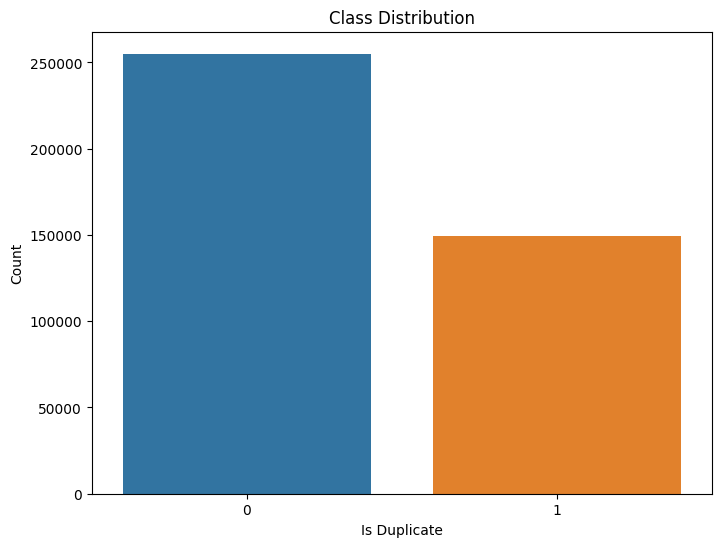

In [ ]:
# Visualize the class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='is_duplicate', data=qp)
plt.title('Class Distribution')
plt.xlabel('Is Duplicate')
plt.ylabel('Count')
plt.show()

## Inference:

From above plot, we can see that the dataset is almost imbalanced, with a higher number of non-duplicate question pairs (class 0) than duplicate question pairs (class 1). Hence, we can use oversampling or undersampling technique to subdue the class imbalance.

## Length of questions

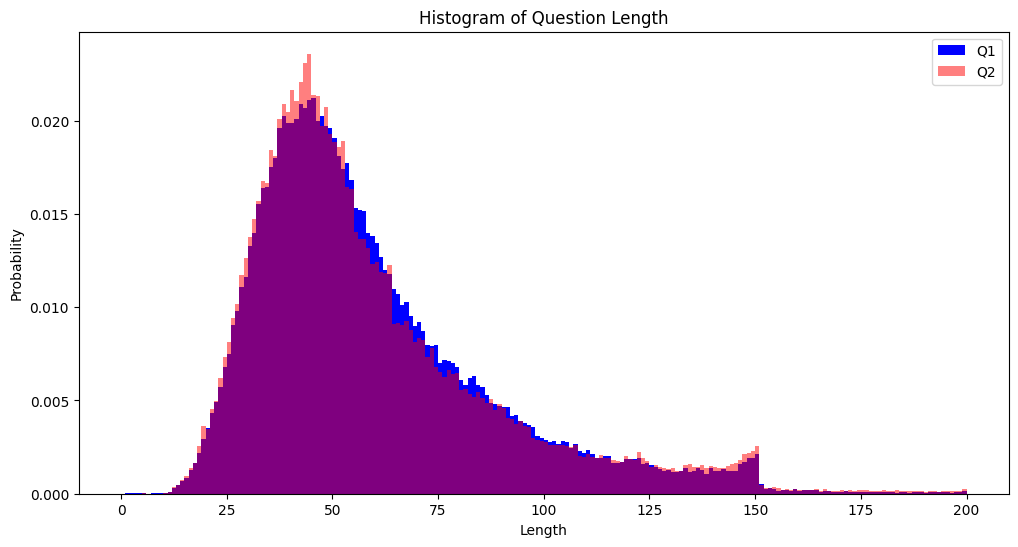

In [ ]:
# Plot histogram of question lengths
plt.figure(figsize=(12, 6))
plt.hist(qp['question1'].str.len(), bins=200, range=[0, 200], color='blue', density=True, label='Q1')
plt.hist(qp['question2'].str.len(), bins=200, range=[0, 200], color='red', density=True, alpha=0.5, label='Q2')
plt.title('Histogram of Question Length')
plt.legend()
plt.xlabel('Length')
plt.ylabel('Probability')
plt.show()

In [ ]:
# Sanity Check
## Check for empty and null strings in questions

empty_q1 = qp[qp['question1'] == ''].shape[0]
empty_q2 = qp[qp['question2'] == ''].shape[0]

print(f"Number of empty strings in 'question1': {empty_q1}")
print(f"Number of empty strings in 'question2': {empty_q2}")

null_q1 = qp['question1'].isnull().sum()
null_q2 = qp['question2'].isnull().sum()

print(f"Number of None values in 'question1': {null_q1}")
print(f"Number of None values in 'question2': {null_q2}")

Number of empty strings in 'question1': 0
Number of empty strings in 'question2': 0
Number of None values in 'question1': 0
Number of None values in 'question2': 0


### Inference:
**There are None values in questions which needs to be handled during tokenization of questions in feature engineering. We can replace them with empty strings before tokenizing**

In [ ]:
# Check for empty strings in 'question1' and 'question2'
empty_q1 = qp['question1'] == ''
empty_q2 = qp['question2'] == ''

print('Number of empty strings in question1:', empty_q1.sum())
print('Number of empty strings in question2:', empty_q2.sum())
print("Total number of rows in Dataset:", qp.shape[0])

Number of empty strings in question1: 0
Number of empty strings in question2: 0
Total number of rows in Dataset: 404312


In [ ]:

# Rows where only 'question1' is empty
only_q1_empty_rows = qp[(qp['question1'] == '') & (qp['question2'] != '')]

# Rows where only 'question2' is empty
only_q2_empty_rows = qp[(qp['question1'] != '') & (qp['question2'] == '')]

only_q1_empty_rows.count()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [ ]:
only_q1_empty_rows.head()

,id,qid1,qid2,question1,question2,is_duplicate


In [ ]:
only_q2_empty_rows.count()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [ ]:
only_q2_empty_rows.head()

,id,qid1,qid2,question1,question2,is_duplicate


In [ ]:
# Get rows where both 'question1' and 'question2' are empty
empty_both_rows = qp[(qp['question1'] == '') & (qp['question2'] == '')]

empty_both_rows.count()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [ ]:
empty_both_rows.head()

,id,qid1,qid2,question1,question2,is_duplicate


In [ ]:
# Calculate the percentage of rows with empty strings in 'question1' only
empty_q1_only_percentage = (only_q1_empty_rows.shape[0] / qp.shape[0]) * 100

# Calculate the percentage of rows with empty strings in 'question2' only
empty_q2_only_percentage = (only_q2_empty_rows.shape[0] / qp.shape[0]) * 100

# Calculate the percentage of rows with empty strings in either 'question1' or 'question2'
empty_either_percentage = ((empty_q1 | empty_q2).sum() / qp.shape[0]) * 100

# Calculate the percentage of rows with empty strings in both 'question1' and 'question2'
empty_both_percentage = (empty_both_rows.shape[0] / qp.shape[0]) * 100

print('Percentage of rows with empty strings in question1 only:', empty_q1_only_percentage)
print('Percentage of rows with empty strings in question2 only:', empty_q2_only_percentage)
print('Percentage of rows with empty strings in either question1 or question2:', empty_either_percentage)
print('Percentage of rows with empty strings in both question1 and question2:', empty_both_percentage)

Percentage of rows with empty strings in question1 only: 0.0
Percentage of rows with empty strings in question2 only: 0.0
Percentage of rows with empty strings in either question1 or question2: 0.0
Percentage of rows with empty strings in both question1 and question2: 0.0


In [ ]:
qp.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?,"I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone and video games?,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Motorolla DCX3400?,How do I hack Motorola DCX3400 for free internet?,0


In [ ]:
qp.shape

(404312, 6)

In [ ]:
qp.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

## Note: Considering deep learning based NLP models like transformer models (BERT or RoBERTa) are designed to learn from raw text data and generate their own text representations, we dont exactly need preprocessing/feature engineering for this context.

## Model Building

In [ ]:
questions_model=qp.copy()
questions_model.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


In [ ]:
questions_model.shape

(404312, 6)

In [ ]:
!pip install transformers

In [ ]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from tqdm import tqdm
import time
from torch.utils.data import Dataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
# Source: https://arxiv.org/pdf/1910.01108v4.pdf


# Split the data into training, validation and testing sets using sklearn's train_test_split function
# The data is split into 80% for training and validation, and 20% for testing
train_val_indices, test_indices = train_test_split(np.arange(len(questions_model)), test_size=0.2)

# Further split the training data into training and validation sets
# The data is split into 85% for training and 15% for validation
train_indices, val_indices = train_test_split(train_val_indices, test_size=0.15)

# Create DataFrames for the training, validation, and testing sets using the indices generated above
train_val = questions_model.iloc[train_val_indices]
test = questions_model.iloc[test_indices]
train = questions_model.iloc[train_indices]
val = questions_model.iloc[val_indices]

In [ ]:
# Define a custom dataset class
class QuoraDataset(Dataset):

    # The constructor takes in the data, a tokenizer, and an optional maximum length for the sequences
    def __init__(self, data, tokenizer, max_len=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    # The __len__ method returns the number of items in the dataset
    def __len__(self):
        return len(self.data)

    # The __getitem__ method takes in an index and returns the corresponding item from the dataset
    def __getitem__(self, idx):

        # Get the row at the given index
        row = self.data.iloc[idx]

        # Get the two questions from the row
        question1 = row['question1']
        question2 = row['question2']

        # Use the tokenizer to encode the two questions into input IDs and attention masks
        # The sequences are padded or truncated to the maximum length
        inputs = self.tokenizer.encode_plus(
            question1, question2, add_special_tokens=True, max_length=self.max_len, padding='max_length', truncation='longest_first'
        )

        # Return a dictionary containing the input IDs, attention masks, and labels
        return {
            'input_ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(row['is_duplicate'], dtype=torch.long)
        }

In [ ]:
# Initialize the tokenizer and the model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

from torch.nn import Dropout

# Add dropout layer in the model
model.classifier = nn.Sequential(
    Dropout(0.5),
    nn.Linear(model.config.dim, model.config.num_labels)
)

# Checking if CUDA is available and setting device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
model = model.to(device)

print(model)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
# Define a function to preprocess the data
def preprocess_data(data, tokenizer, max_len=128):

    # Initialize lists to store the input IDs, attention masks, and labels
    input_ids, attention_mask, labels = [], [], []

    start_time = time.time()

    # Iterate over each row in the data
    for _, row in tqdm(data.iterrows(), total=data.shape[0]):

        # Get the two questions from the row
        question1 = row['question1']
        question2 = row['question2']

        # Use the tokenizer to encode the two questions into input IDs and attention masks
        # The sequences are padded or truncated to the maximum length
        inputs = tokenizer.encode_plus(
            question1, question2, add_special_tokens=True, max_length=max_len, padding='max_length', truncation='longest_first'
        )

        # Append the input IDs, attention masks, and labels to the respective lists
        input_ids.append(inputs['input_ids'])
        attention_mask.append(inputs['attention_mask'])
        labels.append(row['is_duplicate'])

    end_time = time.time()

    print(f"Preprocessing time: {end_time - start_time} seconds")

    return input_ids, attention_mask, labels

# Preprocess the training data
print("Preprocessing train data...")
train_input_ids, train_attention_mask, train_labels = preprocess_data(train, tokenizer)

# Preprocess the validation data
print("Preprocessing val data...")
val_input_ids, val_attention_mask, val_labels = preprocess_data(val, tokenizer)

Preprocessing train data...


 83%|████████▎ | 228640/274931 [02:53<00:34, 1355.91it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
 94%|█████████▍| 259106/274931 [03:16<00:11, 1321.53it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens h

Preprocessing time: 208.53575205802917 seconds
Preprocessing val data...


100%|██████████| 48518/48518 [00:36<00:00, 1336.74it/s]

Preprocessing time: 36.298831939697266 seconds


### Class weights are more direct way to handle class imbalance without the risk of generating synthetic examples (SMOTE) that might not make sense in the context of NLP. **Class weights work by giving more importance to the minority class during the training process, which can help improve the model's performance on the minority class as in our case duplicate question pairs ("1") are minority class which will be handles through this**.

In [ ]:
# Calculate the class frequencies
class_freqs = np.bincount(train_labels)

# Compute the class weights
class_weights = 1. / class_freqs

# Normalize the weights to make them sum to 1
class_weights = class_weights / np.sum(class_weights)

# Convert to torch.Tensor
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Move to device
class_weights = class_weights.to(device)

# Provide the class weights to the loss function
# The loss function will give more importance to the minority class
loss_function = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
# Source: https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
# Source: https://arxiv.org/pdf/2107.06665.pdf (Disparity Between Batches as a Signal for Early Stopping)

# Define a class for early stopping
class EarlyStopping:

    # Initialize the class with patience, verbose, and delta parameters
    def __init__(self, patience=3, verbose=False, delta=0):

        # Patience is the number of epochs with no improvement after which training will be stopped
        self.patience = patience

        # Verbose indicates whether to print a message for each validation accuracy improvement
        self.verbose = verbose

        # Counter for tracking the number of epochs with no improvement
        self.counter = 0

        # Best score achieved so far
        self.best_score = None

        # Flag to stop training
        self.early_stop = False

        # Maximum validation accuracy achieved so far
        self.val_acc_max = np.NINF

        # Minimum change in the monitored quantity to qualify as an improvement
        self.delta = delta

    # Method to call at the end of each epoch
    def __call__(self, val_acc, model):

        score = val_acc

        # If this is the first epoch, save the model and set the best score to the current score
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_acc, model)

        # If the current score is less than the best score plus delta, increment the counter
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')

            # If the counter has reached the patience limit, set the early stop flag to True
            if self.counter >= self.patience:
                self.early_stop = True

        # If the current score is greater than the best score plus delta, save the model and reset the counter
        else:
            self.best_score = score
            self.save_checkpoint(val_acc, model)
            self.counter = 0

    # Method to save the model when the validation accuracy improves
    def save_checkpoint(self, val_acc, model):

        # If verbose is True, print a message indicating that the validation accuracy has improved
        if self.verbose:
            print(f'Validation accuracy increased ({self.val_acc_max:.6f} --> {val_acc:.6f}).  Saving model ...')

        # Save the current model
        torch.save(model.state_dict(), 'checkpoint.pt')

        # Update the maximum validation accuracy
        self.val_acc_max = val_acc

In [ ]:
# Import necessary libraries for optimization and learning rate scheduling
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
import matplotlib.pyplot as plt

# Define the optimizer using the AdamW algorithm with weight decay for regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001, weight_decay=1)

# Define the learning rate scheduler using the CosineAnnealingLR strategy
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

# Set the number of epochs for training
num_epochs = 50

# Initialize the early stopping object with a patience of 3 epochs
early_stopping = EarlyStopping(patience=3, verbose=True)

# Initialize lists to store losses and accuracies for each epoch
train_losses_epoch, train_accuracies_epoch = [], []
val_losses_epoch, val_accuracies_epoch = [], []

# Define a function for a single training step
def train_step(batch):
    """
    Function to perform a single training step.

    Args:
        batch (dict): A dictionary containing the input tensors for a single batch.

    Returns:
        tuple: A tuple containing the loss and accuracy for the batch.
    """

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(batch['input_ids'].to(device), attention_mask=batch['attention_mask'].to(device))

    # Compute the loss
    loss = loss_function(outputs.logits, batch['labels'].to(device))

    # Compute the accuracy
    acc = (outputs.logits.argmax(dim=1) == batch['labels'].to(device)).float().mean()

    # Backward pass
    loss.backward()

    # Update the weights
    optimizer.step()

    # Return the loss and accuracy
    return loss.item(), acc.item()

# Import the KFold class for cross-validation
from sklearn.model_selection import KFold

# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1

# For each fold in the cross-validation
for train, val in kfold.split(questions_model):

    # Split the data into training and validation sets
    train_data = questions_model.iloc[train]
    val_data = questions_model.iloc[val]

    # Create the Dataset objects for the training and validation sets
    train_dataset = QuoraDataset(train_data, tokenizer)
    val_dataset = QuoraDataset(val_data, tokenizer)

    # Create DataLoader objects for the training and validation sets
    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=512, num_workers=4)

    # For each epoch
    for epoch in range(num_epochs):

        # Set the model to training mode
        model.train()

        # Initialize lists to store the loss and accuracy values for each batch during training
        train_losses, train_accs = [], []

        start_time = time.time()

        # For each batch in the training DataLoader
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1} Training'):

            # Perform a training step and get the loss and accuracy
            loss, acc = train_step(batch)

            # Append the loss and accuracy to the lists
            train_losses.append(loss)
            train_accs.append(acc)

        # Compute the average loss and accuracy for the epoch during training
        train_loss, train_acc = sum(train_losses) / len(train_losses), sum(train_accs) / len(train_accs)

        # Update the learning rate
        scheduler.step()

        end_time = time.time()

        # Print the duration of the epoch
        print(f"Training time for epoch: {end_time - start_time} seconds")

        # Append the average loss and accuracy for the epoch during training to the lists
        train_losses_epoch.append(train_loss)
        train_accuracies_epoch.append(train_acc)

        # Set the model to evaluation mode
        model.eval()

        # Initialize lists to store the loss and accuracy values, predictions, and labels for each batch during validation
        val_losses, val_accs, val_preds, val_labels = [], [], [], []

        start_time = time.time()

        # For each batch in the validation DataLoader
        with torch.no_grad():

            for batch in tqdm(val_loader, desc=f'Epoch {epoch+1} Validation'):

                # Forward pass
                outputs = model(batch['input_ids'].to(device), attention_mask=batch['attention_mask'].to(device))

                # Compute the loss
                loss = loss_function(outputs.logits, batch['labels'].to(device))

                # Compute the accuracy
                acc = (outputs.logits.argmax(dim=1) == batch['labels'].to(device)).float().mean()

                # Append the loss and accuracy to the lists
                val_losses.append(loss.item())

                val_accs.append(acc.item())
                val_preds.extend(outputs.logits.argmax(dim=1).cpu().numpy())
                val_labels.extend(batch['labels'].cpu().numpy())

        val_loss, val_acc = sum(val_losses) / len(val_losses), sum(val_accs) / len(val_accs)
        end_time = time.time()

        print(f"Validation time for epoch: {end_time - start_time} seconds")
        print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'Epoch: {epoch+1:02} | Val Loss: {val_loss:.3f} | Val Acc: {val_acc*100:.2f}%')
        print(f'Validation F1 Score: {f1_score(val_labels, val_preds, average="weighted"):.3f}')

        # At the end of each epoch, append the average loss and accuracy to the lists
        val_losses_epoch.append(val_loss)
        val_accuracies_epoch.append(val_acc)

        # Check the difference between training and validation accuracy
        if abs(train_acc - val_acc) > 0.05:
            print("Stopping training: the difference between training and validation accuracy exceeded 5%")
            break

        # Early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    fold_no = fold_no + 1

Epoch 1 Training:   0%|          | 0/632 [00:00<?, ?it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 1 Training:   8%|▊         | 49/6

Training time for epoch: 677.1659388542175 seconds


Epoch 1 Validation:   0%|          | 0/158 [00:00<?, ?it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 1 Validation: 100%|██████████| 158/158 [00:56<00:00,  2.80it/s]


Validation time for epoch: 56.493561029434204 seconds
Epoch: 01 | Train Loss: 0.423 | Train Acc: 78.82%
Epoch: 01 | Val Loss: 0.341 | Val Acc: 83.89%
Validation F1 Score: 0.841
Stopping training: the difference between training and validation accuracy exceeded 7%


Epoch 1 Training:   1%|          | 5/632 [00:06<12:16,  1.18s/it]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 1 Training:  18%|█▊        | 112/632 [02:00<09:15,  1.07s/it]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty eve

Training time for epoch: 675.8913295269012 seconds


Epoch 1 Validation:  11%|█         | 17/158 [00:07<00:49,  2.84it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 1 Validation: 100%|██████████| 158/158 [00:56<00:00,  2.79it/s]


Validation time for epoch: 56.6243736743927 seconds
Epoch: 01 | Train Loss: 0.326 | Train Acc: 84.87%
Epoch: 01 | Val Loss: 0.290 | Val Acc: 86.78%
Validation F1 Score: 0.869
Validation accuracy increased (-inf --> 0.289668).  Saving model ...


Epoch 2 Training:   6%|▌         | 36/632 [00:39<10:36,  1.07s/it]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 2 Training:  23%|██▎       | 148/632 [02:39<08:37,  1.07s/it]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty ev

Training time for epoch: 676.0048208236694 seconds


Epoch 2 Validation:  11%|█         | 17/158 [00:07<00:49,  2.85it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 2 Validation: 100%|██████████| 158/158 [00:56<00:00,  2.80it/s]


Validation time for epoch: 56.435964584350586 seconds
Epoch: 02 | Train Loss: 0.287 | Train Acc: 86.91%
Epoch: 02 | Val Loss: 0.280 | Val Acc: 86.77%
Validation F1 Score: 0.870
EarlyStopping counter: 1 out of 3


Epoch 3 Training:   0%|          | 0/632 [00:00<?, ?it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 3 Training:   8%|▊         | 51/632 [00:55<10:20,  1.07s/it]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some

Training time for epoch: 676.3610298633575 seconds


Epoch 3 Validation:  11%|█         | 17/158 [00:07<00:49,  2.85it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 3 Validation: 100%|██████████| 158/158 [00:56<00:00,  2.80it/s]


Validation time for epoch: 56.41185426712036 seconds
Epoch: 03 | Train Loss: 0.260 | Train Acc: 88.31%
Epoch: 03 | Val Loss: 0.269 | Val Acc: 87.72%
Validation F1 Score: 0.879
EarlyStopping counter: 2 out of 3


Epoch 4 Training:   2%|▏         | 11/632 [00:12<11:09,  1.08s/it]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 4 Training:   4%|▍         | 24/632 [00:26<10:49,  1.07s/it]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty eve

Training time for epoch: 676.4549996852875 seconds


Epoch 4 Validation:  11%|█         | 17/158 [00:07<00:49,  2.85it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 4 Validation: 100%|██████████| 158/158 [00:56<00:00,  2.79it/s]


Validation time for epoch: 56.5703661441803 seconds
Epoch: 04 | Train Loss: 0.238 | Train Acc: 89.40%
Epoch: 04 | Val Loss: 0.266 | Val Acc: 88.99%
Validation F1 Score: 0.891
EarlyStopping counter: 3 out of 3
Early stopping


Epoch 1 Training:  34%|███▍      | 214/632 [03:50<07:26,  1.07s/it]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 1 Training:  54%|█████▍    | 340/632 [06:04<05:11,  1.07s/it]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty e

Training time for epoch: 676.5672147274017 seconds


Epoch 1 Validation:   0%|          | 0/158 [00:00<?, ?it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 1 Validation:  24%|██▍       | 

Validation time for epoch: 56.606645345687866 seconds
Epoch: 01 | Train Loss: 0.237 | Train Acc: 89.53%
Epoch: 01 | Val Loss: 0.198 | Val Acc: 91.50%
Validation F1 Score: 0.916
EarlyStopping counter: 4 out of 3
Early stopping


Epoch 1 Training:   0%|          | 0/632 [00:00<?, ?it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 1 Training:   2%|▏         | 13/632 [00:15<11:04,  1.07s/it]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some

Training time for epoch: 676.2345094680786 seconds


Epoch 1 Validation:  27%|██▋       | 43/158 [00:16<00:40,  2.86it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 1 Validation:  32%|███▏      | 50/158 [00:18<00:37,  2.86it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty

Validation time for epoch: 56.61153745651245 seconds
Epoch: 01 | Train Loss: 0.227 | Train Acc: 90.03%
Epoch: 01 | Val Loss: 0.180 | Val Acc: 92.23%
Validation F1 Score: 0.923
EarlyStopping counter: 5 out of 3
Early stopping


Epoch 1 Training:  42%|████▏     | 265/632 [04:44<06:32,  1.07s/it]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 1 Training:  62%|██████▏   | 389/632 [06:56<04:19,  1.07s/it]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty e

Training time for epoch: 676.1731083393097 seconds


Epoch 1 Validation:   0%|          | 0/158 [00:00<?, ?it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 1 Validation:   1%|▏         | 2/158 [00:01<02:06,  1.23it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if s

Validation time for epoch: 56.54940056800842 seconds
Epoch: 01 | Train Loss: 0.218 | Train Acc: 90.46%
Epoch: 01 | Val Loss: 0.177 | Val Acc: 92.45%
Validation F1 Score: 0.925
EarlyStopping counter: 6 out of 3
Early stopping


In [ ]:
# Save the model
torch.save(model.state_dict(), 'distilbert50_v2.pth')

In [ ]:
# Import the necessary library for saving the model
import pickle

# Save the trained model as a pickle file
with open('distilbert50_v2.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
# Create a Dataset object for the test data
test_dataset = QuoraDataset(test, tokenizer)

# Create a DataLoader object for the test data
test_loader = DataLoader(test_dataset, batch_size=512, num_workers=4)

# Initialize lists to store the losses, accuracies, predictions, and labels for the test data
test_losses, test_accs, test_preds, test_labels = [], [], [], []

start_time = time.time()

# Set the model to evaluation mode
with torch.no_grad():

    # Iterate over batches in the test data
    for batch in tqdm(test_loader, desc='Testing'):

        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(batch['input_ids'].to(device), attention_mask=batch['attention_mask'].to(device))

        # Calculate the loss
        loss = loss_function(outputs.logits, batch['labels'].to(device))

        # Calculate the accuracy
        acc = (outputs.logits.argmax(dim=1) == batch['labels'].to(device)).float().mean()

        # Append the loss and accuracy to the respective lists
        test_losses.append(loss.item())
        test_accs.append(acc.item())

        # Append the predictions and labels to the respective lists
        test_preds.extend(outputs.logits.argmax(dim=1).cpu().numpy())
        test_labels.extend(batch['labels'].cpu().numpy())

# Calculate the average loss and accuracy
test_loss, test_acc = sum(test_losses) / len(test_losses), sum(test_accs) / len(test_accs)

end_time = time.time()

# Print the time taken for testing, the test loss, and the test accuracy
print(f"Testing time: {end_time - start_time} seconds")
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

# Calculate and print the F1 score
print(f'Test F1 Score: {f1_score(test_labels, test_preds, average="weighted"):.3f}')

Testing:  54%|█████▍    | 86/158 [00:31<00:25,  2.86it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Testing: 100%|██████████| 158/158 [00:56<00:00,  2.78it/s]

Testing time: 56.74489665031433 seconds
Test Loss: 0.187 | Test Acc: 91.96%
Test F1 Score: 0.921


## Training and Validation loss over time

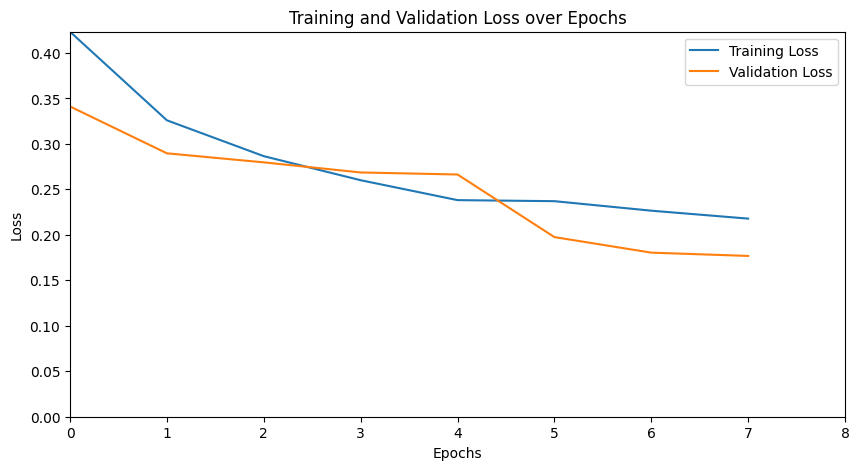

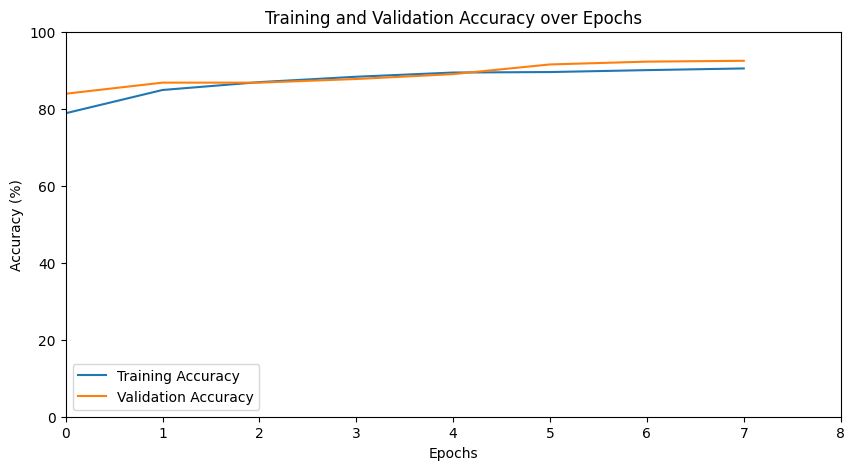

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss over Epochs")
plt.plot(train_losses_epoch, label='Training Loss')
plt.plot(val_losses_epoch, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(0, len(train_losses_epoch))  # Set x-axis limit to number of epochs
plt.ylim(0, max(max(train_losses_epoch), max(val_losses_epoch)))  # Set y-axis limit to maximum loss
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy over Epochs")
plt.plot([acc * 100 for acc in train_accuracies_epoch], label='Training Accuracy')  # Convert to percentage
plt.plot([acc * 100 for acc in val_accuracies_epoch], label='Validation Accuracy')  # Convert to percentage
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.xlim(0, len(train_accuracies_epoch))  # Set x-axis limit to number of epochs
plt.ylim(0, 100)  # Set y-axis limit to 100 as accuracy is in percentage
plt.legend()
plt.show()

In [ ]:
!pip install gradio # Install the gradio library for creating a web interface for the model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 18.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 7.3 MB/s eta 0:00:00
  

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model
model_path = 'distilbert50_v2.pth' # Adjust the path if needed
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval() # Set the model to evaluation mode

# Initialize the tokenizer and the model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
import gradio as gr

# Define a function to make predictions using the model
def predict(question1, question2):
    """
    Function to make predictions using the trained model.

    Args:
        question1 (str): The first question to be compared.
        question2 (str): The second question to be compared.

    Returns:
        str: 'Duplicate' if the model predicts the questions to be duplicates, 'Not duplicate' otherwise.
    """

    # Tokenize the questions
    inputs = tokenizer.encode_plus(
        question1, question2, add_special_tokens=True, max_length=128, padding='max_length', truncation='longest_first'
    )

    # Convert the inputs to tensors
    input_ids = torch.tensor([inputs['input_ids']], dtype=torch.long)
    attention_mask = torch.tensor([inputs['attention_mask']], dtype=torch.long)

    # Move the tensors to the device
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    # Make a prediction using the model
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    # Get the predicted class
    prediction = outputs.logits.argmax(dim=1).item()

    # Return the prediction
    return 'Duplicate' if prediction == 1 else 'Not duplicate'

In [ ]:
# Create a web interface for the model using gradio
iface = gr.Interface(fn=predict, inputs=["text", "text"], outputs="text")

# Launch the interface
iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://b8dba6e81c2f1b4ab8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
# Clearing GPU cache
torch.cuda.empty_cache()